In [881]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from datetime import datetime
import math
import scipy.stats
import random
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


plt.style.use('ggplot')
random.seed(123)
np.set_printoptions(suppress=True)

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [708]:
# Loan_id - A unique loan number assigned to each loan customers

# Loan_status - Whether a loan is paid off, in collection, new customer yet to payoff, or paid off after the collection efforts

# Principal - Basic principal loan amount at the origination

# terms - Can be weekly (7 days), biweekly, and monthly payoff schedule

# Effective_date - When the loan got originated and took effects

# Due_date - Since it’s one-time payoff schedule, each loan has one single due date

# Paidoff_time - The actual time a customer pays off the loan

# Pastdue_days - How many days a loan has been past due

# Age, education, gender A customer’s basic demographic information

In [709]:
# Hypothesis Testing tool kit

def draw_bs_reps(data, func, size = 1):
    """Draw bootstrap replicates"""
    
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, len(data)))
    return bs_replicates

def draw_bs_ts(data1, data2, orig_data, size  = 1):
    data1_shifted = data1 - np.mean(data1) + np.mean(orig_data)
    data2_shifted = data2 - np.mean(data2) + np.mean(orig_data)
    
    bs_replicates1 = draw_bs_reps(data1, np.mean, 10000)
    bs_replicates2 = draw_bs_reps(data2, np.mean, 10000)
    
    bs_replicates_diff = bs_replicates1 - bs_replicates2
    empirical_diff_means_age = diff_of_means(data1, data2)

    p = np.sum(bs_replicates_diff >= empirical_diff_means_age)/len(bs_replicates_diff)
    print('Two sample test statistic p value = ',p)


def conf_int(data, crit = 5):
    return np.percentile(data, [0 + crit/2, 100 - crit/2])

def norm_test(data, alpha = .05):
    """Test data for normality: Null hypothesis data normally distributed"""
    
    if scipy.stats.mstats.normaltest(data).pvalue < alpha:
        print("Sample Not Normally Distributed")
    else:
        print("Sample Normally Distributed ")
    print("P Value: " + str(scipy.stats.mstats.normaltest(data).pvalue),
          "Mean: " + str(np.mean(data)),
          "Std: " + str(np.std(data)),
          "Conf Int: " + str(conf_int(data))         
         ) 


def diff_of_means(data_1, data_2):
    """Difference in means of two arrays"""
    
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

def chi_test(data):
    ct = pd.crosstab(data, df.late)
    print('Chi Squared p value = ', scipy.stats.chi2_contingency(ct)[1])
    display(ct)

In [710]:
print(df.isnull().sum())
df.groupby('loan_status')['loan_status'].count()

loan_status     0
principal       0
terms           0
age             0
education       0
gender          0
days_overdue    0
late            0
dtype: int64


loan_status
collection            100
collection_paidoff    100
paidoff               300
Name: loan_status, dtype: int64

In [711]:
# Import data and Read data

df = pd.read_csv('C:/Users/dmitr/Documents/Work/Projects/Kaggle/Loan Data/Loan payments data.csv')
df['education'] = df['education'].replace(to_replace = 'Bechalor', value = 'Bachelor')
df.rename(columns={'Principal': 'principal', 'Gender': 'gender'}, inplace=True)

display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
Loan_ID           500 non-null object
loan_status       500 non-null object
principal         500 non-null int64
terms             500 non-null int64
effective_date    500 non-null object
due_date          500 non-null object
paid_off_time     400 non-null object
past_due_days     200 non-null float64
age               500 non-null int64
education         500 non-null object
gender            500 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 43.0+ KB


None

,Loan_ID,loan_status,principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bachelor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bachelor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female


In [712]:
# Data cleaning 

object_cols = ['loan_status','education','gender']
date_cols = ['effective_date','due_date','paid_off_time']
df[object_cols] = df[object_cols].apply(lambda x: x.str.lower(), axis = 1)
df[date_cols] = df[date_cols].apply(pd.to_datetime)
df['days_overdue'] = (df.paid_off_time - df.due_date).astype('timedelta64[D]').fillna(df.past_due_days)
df['late'] = df['days_overdue'].apply(lambda x: 0 if x <= 0 else 1)
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'male' else 0)

df = df.drop(date_cols + ['past_due_days','Loan_ID'], axis = 1)
df.head()

,loan_status,principal,terms,age,education,gender,days_overdue,late
0,paidoff,1000,30,45,high school or below,1,-23.0,0
1,paidoff,1000,30,50,bachelor,0,0.0,0
2,paidoff,1000,30,33,bachelor,0,-12.0,0
3,paidoff,1000,15,27,college,1,0.0,0
4,paidoff,1000,30,28,college,0,-15.0,0


In [713]:
# Add levels to ordinal values

print(df.education.unique())

df.education = df.education.astype(pd.api.types.CategoricalDtype(
    ordered=True,categories=['high school or below', 'college', 'bachelor', 'master or above']))

df.education.cat

['high school or below' 'bachelor' 'college' 'master or above']


In [714]:
# Let us observe two populations: 1. Late on repaying loan 2. Not late on repaying loan


df_late = df[df.late == 1]
df_notlate = df[df.late == 0]

display_side_by_side(
    df_late.describe().round(),
    df_notlate.describe().round()
)

display_side_by_side(
    df_late.select_dtypes(include='object').describe(),
    df_notlate.select_dtypes(include='object').describe()
)

,principal,terms,age,gender,days_overdue,late
count,201.0,201.0,201.0,201.0,201.0,201.0
mean,956.0,24.0,31.0,1.0,36.0,1.0
std,88.0,7.0,6.0,0.0,29.0,0.0
min,500.0,7.0,18.0,0.0,1.0,1.0
25%,1000.0,15.0,26.0,1.0,3.0,1.0
50%,1000.0,30.0,30.0,1.0,36.0,1.0
75%,1000.0,30.0,35.0,1.0,60.0,1.0
max,1000.0,30.0,50.0,1.0,76.0,1.0
,principal,terms,age,gender,days_overdue,late
count,299.0,299.0,299.0,299.0,299.0,299.0


,loan_status
count,201
unique,3
top,collection
freq,100
,loan_status
count,299
unique,1
top,paidoff
freq,299


Sample Not Normally Distributed
P Value: 0.000156905983211 Mean: 30.965174129353233 Std: 6.135597226667339 Conf Int: [ 22.  46.]
Sample Not Normally Distributed
P Value: 6.54476771136e-06 Mean: 31.217391304347824 Std: 6.038025980666363 Conf Int: [ 21.  45.]


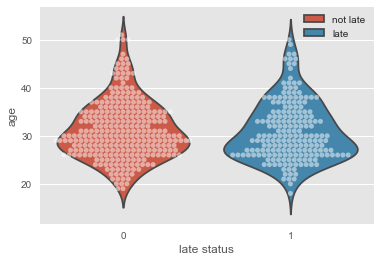

Kolmogorov-Smirnov p value:  0.634042935746
Two sample test statistic p value =  0.4989


In [715]:
# Null Hypothesis: Late and Not Late groups both have the same mean age
# Test statistic: Mean 

# Let us begin with age. Descriptive analytics show us that age is not normally distributed in either sample, but looks identically distributed let us confirm
norm_test(df_late.age)
norm_test(df_notlate.age)

_ = sns.violinplot(x="late", y="age", data=df, inner=None)
_ = sns.swarmplot(x="late", y="age", data=df, color="w", alpha=.5)
_ = plt.xlabel('late status')
_ = plt.ylabel('age')
_ = plt.legend(['not late', 'late'])

plt.show()

# Kolmogorov-Smirnov statistic, based on large p value we cannot reject that both samples are not distributed identically 
print("Kolmogorov-Smirnov p value: ",scipy.stats.ks_2samp(df_late.age, df_notlate.age).pvalue)

# Using bootstrap method we reject the alternative hypothesis that the two groups' age means are significantly different
draw_bs_ts(df_late.age, df_notlate.age, df.age, 10000)


In [716]:
# Null hypothesis: Categorical principal, education, gender, terms are identically distributed amongst late and non late groups

# Chi Square on ordinal values, contingency table of observed counts
# Assumption #1: Two variables measured at an ordinal or nominal level
# Assumption #2: Two variable should consist of two or more categorical, independent groups
# Assumption #3: Each category excedes count of 5

# Education is not statistically significant

print('Education')

education_grp = df.education.map(lambda x: 'bachelor or above' if x in ['bachelor','master or above'] else x)

display(pd.crosstab(df.education, df.late))
chi_test(education_grp)

Education


late,0,1
education,,
high school or below,122,87
college,133,87
bachelor,41,26
master or above,3,1


Chi Squared p value =  0.837149395354


late,0,1
education,,
bachelor or above,44,27
college,133,87
high school or below,122,87


In [717]:
# terms is not statistically significant

print('terms')
display(pd.crosstab(df.terms, df.late))
terms_grp = df.terms.map(lambda x: '15 or less' if x <= 15 else '30')
chi_test(terms_grp)

terms


late,0,1
terms,,
7,20,1
15,127,80
30,152,120


Chi Squared p value =  0.0628980961579


late,0,1
terms,,
15 or less,147,81
30,152,120


In [718]:
# principle is not statistically significant

print('principal')
display(pd.crosstab(df.principal, df.late))
principal_grp = df.principal.map(lambda x: 'less than 1000' if x < 1000 else '1000')
chi_test(principal_grp)

principal


late,0,1
principal,,
300,6,0
500,2,1
700,1,0
800,69,42
900,2,0
1000,219,158


Chi Squared p value =  0.207928427478


late,0,1
principal,,
1000,219,158
less than 1000,80,43


In [719]:
# Fisher Test for 2 by 2 of observed counts 
# Assumption 1: 2 x 2 matrix
# Assumption 2: Each category > 5

# gender is not statistically significant

print('gender')
print('Fisher test p value: ', scipy.stats.fisher_exact(pd.crosstab(df.gender, df.late))[1])
display(pd.crosstab(df.gender, df.late))

gender
Fisher test p value:  0.0999932570087


late,0,1
gender,,
0,53,24
1,246,177


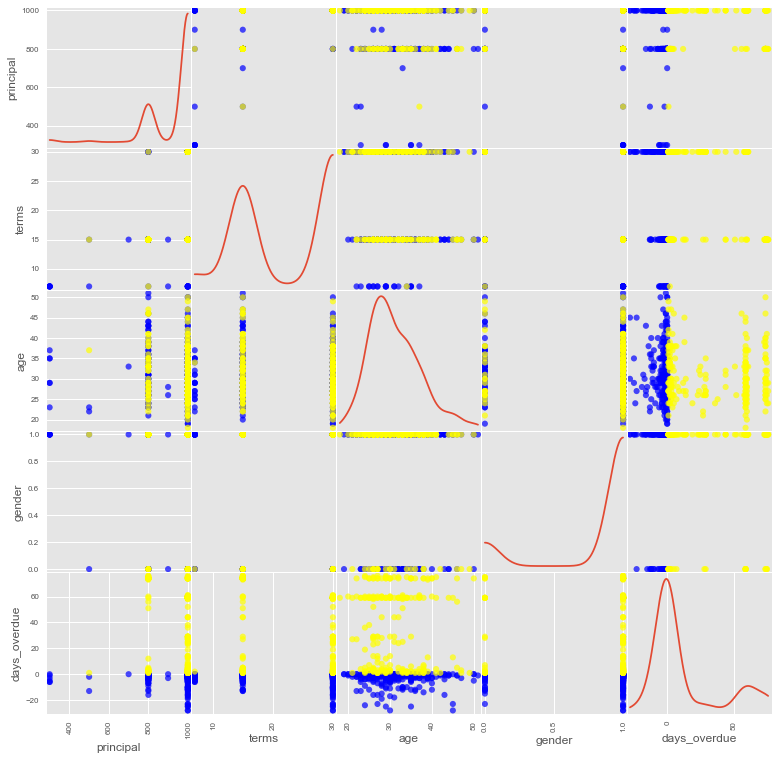

In [721]:
# Yellow: late; Blue: not late

colors_palette = {0: "blue", 1: "yellow", 2: "green"}
colors = [colors_palette[c] for c in df.late] 
_ = scatter_matrix(df.loc[:, ~df.columns.isin(['late'])], 
                   c = colors, figsize = [13,13], s = 150, grid = True, alpha = .7, diagonal='kde')

plt.show()


In [750]:
# Dummy variable categorical variables in table

def rmcol(data, cols):
    return data.loc[:, ~data.columns.isin(cols)]

df_dum = pd.get_dummies(rmcol(df,['loan_status','days_overdue','late']))
df_dum.head()

,principal,terms,age,gender,education_high school or below,education_college,education_bachelor,education_master or above
0,1000,30,45,1,1,0,0,0
1,1000,30,50,0,0,0,1,0
2,1000,30,33,0,0,0,1,0
3,1000,15,27,1,0,1,0,0
4,1000,30,28,0,0,1,0,0


In [754]:
# Scale the data

df_scl = pd.DataFrame(preprocessing.scale(df_mod), columns = df_dum.columns.values)
df_scl.head()

,principal,terms,age,gender,education_high school or below,education_college,education_bachelor,education_master or above
0,0.493377,0.897891,2.284043,0.426653,1.179976,-0.886405,-0.393363,-0.089803
1,0.493377,0.897891,3.106587,-2.343823,-0.847475,-0.886405,2.542181,-0.089803
2,0.493377,0.897891,0.309935,-2.343823,-0.847475,-0.886405,2.542181,-0.089803
3,0.493377,-0.978972,-0.677119,0.426653,-0.847475,1.128152,-0.393363,-0.089803
4,0.493377,0.897891,-0.512610,-2.343823,-0.847475,1.128152,-0.393363,-0.089803


In [786]:
# Split data into train and test

X_train, X_test, y_train, y_test = train_test_split(df_scl, df.late, 
                                                    test_size=0.2, shuffle  = True, random_state = 123, stratify = df.late)
display(X_train.head(), y_train.head())

,principal,terms,age,gender,education_high school or below,education_college,education_bachelor,education_master or above
465,0.493377,0.897891,2.942078,-2.343823,1.179976,-0.886405,-0.393363,-0.089803
395,0.493377,0.897891,-1.006137,0.426653,1.179976,-0.886405,-0.393363,-0.089803
79,0.493377,0.897891,2.119534,-2.343823,1.179976,-0.886405,-0.393363,-0.089803
339,0.493377,-0.978972,1.296989,0.426653,1.179976,-0.886405,-0.393363,-0.089803
228,-1.243866,-0.978972,-0.841628,0.426653,1.179976,-0.886405,-0.393363,-0.089803


465    1
395    1
79     0
339    1
228    0
Name: late, dtype: int64

In [787]:
display(X_train.shape, X_test.shape)

(400, 8)

(100, 8)

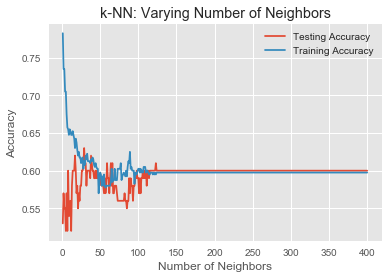

Accuracy:  [ 0.63] Number of Neighbors:  [29]


In [858]:
# Explain late status using k Neighbors

myacc = np.empty(len(X_train))
mytr = np.empty(len(X_train))

for i in range(len(X_train)):
    knn = KNeighborsClassifier(n_neighbors = i + 1)
    knn.fit(X_train, y_train)
    myacc[i] = knn.score(X_test, y_test)
    mytr[i] = knn.score(X_train, y_train)
    

_ = plt.plot((np.arange(400) + 1), myacc)
_ = plt.plot((np.arange(400) + 1), mytr)
_ = plt.title('k-NN: Varying Number of Neighbors')
_ = plt.xlabel('Number of Neighbors')
_ = plt.ylabel('Accuracy')
_ = plt.legend(['Testing Accuracy','Training Accuracy'])
plt.show()

# Identify optimal k neighbors

loc_max = np.where(myacc == max(myacc))

print(
    "Accuracy: ", myacc[loc_max],
    "Number of Neighbors: ", (np.arange(400) + 1)[loc_max]
)

,principal,terms,age,gender,days_overdue,education_high school or below,education_college,education_bachelor,education_master or above
principal,1.000000,0.534302,-0.092613,-0.008355,0.028579,0.058863,-0.014139,0.005385,-0.267711
terms,0.534302,1.000000,-0.074259,0.008630,0.014389,0.085635,-0.015265,-0.067003,-0.132860
age,-0.092613,-0.074259,1.000000,-0.053843,-0.042974,0.036526,-0.105734,0.065898,0.134940
gender,-0.008355,0.008630,-0.053843,1.000000,0.081701,0.013324,0.009823,-0.043625,0.038315
days_overdue,0.028579,0.014389,-0.042974,0.081701,1.000000,0.062002,-0.051111,-0.018407,0.011900
education_high school or below,0.058863,0.085635,0.036526,0.013324,0.062002,1.000000,-0.751206,-0.333365,-0.076105
education_college,-0.014139,-0.015265,-0.105734,0.009823,-0.051111,-0.751206,1.000000,-0.348679,-0.079602
education_bachelor,0.005385,-0.067003,0.065898,-0.043625,-0.018407,-0.333365,-0.348679,1.000000,-0.035325
education_master or above,-0.267711,-0.132860,0.134940,0.038315,0.011900,-0.076105,-0.079602,-0.035325,1.000000


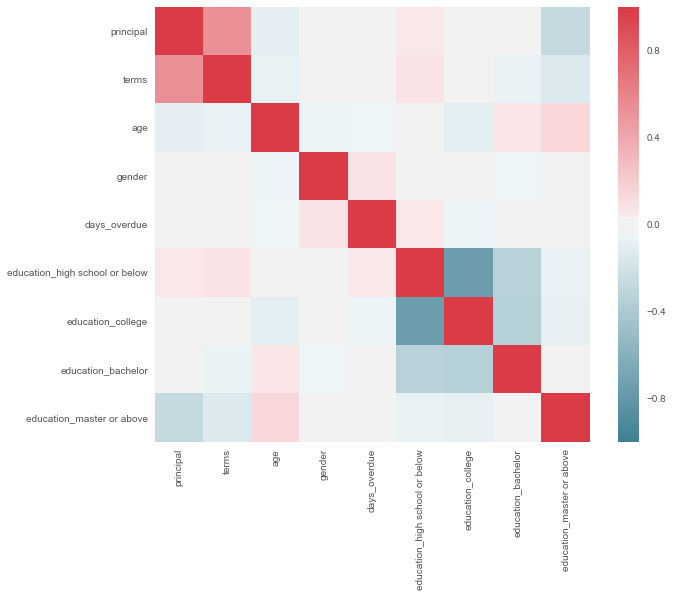

In [859]:
# Check the independence between the independent variables, multicollinearity


f, ax = plt.subplots(figsize=(10, 8))
corr = pd.get_dummies(df.loc[:, ~df.columns.isin(['late', 'loan_status'])]).corr()
sns.heatmap(corr, vmin = -1, vmax = 1, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

display(corr)

In [897]:
X_train, X_test, y_train, y_test = train_test_split(df_dum, df.late, 
                                                    test_size=0.2, shuffle  = True, random_state = 123, stratify = df.late)
display(X_train.head(), y_train.head())
X_train.info()

,principal,terms,age,gender,education_high school or below,education_college,education_bachelor,education_master or above
465,1000,30,49,0,1,0,0,0
395,1000,30,25,1,1,0,0,0
79,1000,30,44,0,1,0,0,0
339,1000,15,39,1,1,0,0,0
228,800,15,26,1,1,0,0,0


465    1
395    1
79     0
339    1
228    0
Name: late, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 465 to 498
Data columns (total 8 columns):
principal                         400 non-null int64
terms                             400 non-null int64
age                               400 non-null int64
gender                            400 non-null int64
education_high school or below    400 non-null uint8
education_college                 400 non-null uint8
education_bachelor                400 non-null uint8
education_master or above         400 non-null uint8
dtypes: int64(4), uint8(4)
memory usage: 17.2 KB


In [943]:
classifier = LogisticRegression(random_state=123, solver = 'liblinear')
classifier.fit(X_train, y_train)

prob_score = classifier.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(np.array(y_test), prob_score, pos_label = 1)

y_pred = classifier.predict(X_test)

confusion_mx = metrics.confusion_matrix(np.array(y_test),np.array(y_pred))
print(confusion_mx)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

print(X_train.columns.values,classifier.coef_)

[[58  2]
 [39  1]]
Accuracy of logistic regression classifier on test set: 0.59
['principal' 'terms' 'age' 'gender' 'education_high school or below'
 'education_college' 'education_bachelor' 'education_master or above'] [[ 0.00010568  0.02530521 -0.01055754  0.27923514 -0.14800567 -0.27850764
  -0.13523963 -0.20818285]]


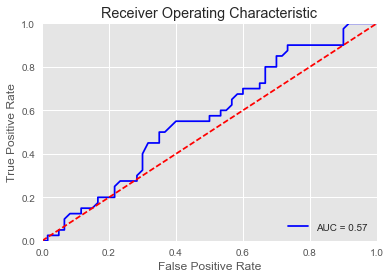

In [944]:
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()